<a id='content'></a>
 **План исследования:**
- [1. Обзор данных](#1)
- [2. Исследовательский анализ данных (EDA)](#2)
- [3. Построение модели прогнозирования](#3)
- [4. Кластеризация клиентов](#4)
- [5. Вывод исследования](#5)

In [1]:
# импортируем библиотеки 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# добавим опции
pd.set_option('display.max_columns', None)

# отключим предупреждения

import warnings
warnings.simplefilter("ignore")


<a id='1'></a>
## [1. Обзор данных](#content)

In [2]:
# загрузим данные и поместим в переменную df

try:
    df = pd.read_csv('data\gym_churn.csv')
except:
    df = pd.read_csv('link to the file')



In [3]:
# выведем размер датафрейма и первые 5 строк

print('Размер таблицы', df.shape)

display(df.head())

Размер таблицы (4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Описание данных:**

- Данные клиента за предыдущий до проверки факта оттока месяц:
 - `gender` — пол;
 - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
 - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - `Phone` — наличие контактного телефона;
 - `Age` — возраст;
 - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
 - `Group_visits` — факт посещения групповых занятий;
 - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
 - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
 - `Churn` — факт оттока в текущем месяце.

**Вывод подраздела:**

В нашем распоряжении данные:
 - размер: **4 000** наблюдений и **14** признаков;
 - в строках у нас хранятся наблюдения об 1 клиенте фитнес-цента;
 - в столбцах у нас признаки присущи клиенту: пол, близость до фитнес-центра, партнерские программы, промо, телефон, возраст, длительность посещения (в месяцах), длительность текущего абонемента и срок его окончания, ходит ли клиент на групповые занятия, частота его посещений за все время и за предыдущий месяц, расходы на доп. услуги предлагаемые в фитнес-центре, а также присутствует факт оттока в текущем месяце.

<a id='2'></a>
## [2. Исследовательский анализ данных (EDA)](#content)

Мы загрузили предоставленные нам данные и немного изучили их. Чтобы двигаться дальше, давайте сформулируем нашу **Бизнес-задачу** - это поможет нам сфокусироваться на исследовании более точнее.

**Бизнес-задача:**
 - **Что мы делаем?** Мы разрабатываем стратегию взаимодействия с клиентами на основе аналитических данных;
 
 
 - **Для чего?** Для того чтобы подготовить план действия по удержанию клиентов;
 
 
 - **Что будем прогнозировать?** Будем искать взаимосвязь среди признаков поведения различных клиентов, чтобы найти те признаки которые присущи клиентам уходящим в отток, напомню, в данной задаче оттоком считаем то, что за последний месяц клиент ни разу не посетил спортзал;
 
 
 - **Какими данными распологаем?** В нашем распоряжении 4000 наблюдений с 14 признаками поведения клиентов за предыдущие месяца; 
 
 
 - **Для кого делаем?** Для отдела по работе с клиентами;
 
 
 - **Как будет использоватся модель?** В данном исследовании мы постараемся построить модель таким образом, чтобы она смогла предсказывать отток клиентов на следующий месяц - эти данные будут использоваться отделам по работе с клиентами, что постараться уменьшить отток клиентов. Дополнительно мы изучим поведение клиентов, постараемся их разбить на группы с общими признаками. Вся эта информация поможет правильно выстроить стратегию для работы с клиентами;
 
 
 - **Итог:** Нам необходимо построить модель для предсказывания оттока клиентов на следующий месяц, используя для этого данные о поведении клиентов. На основе этой модели отдел по работе с клиентами будет выстраивать стратегию по удержанию клиентов.

**Давайте приступим к EDA-анализу**

In [4]:
# изучим данные

display(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Изучив данные мы видим:**
 - у нас нет явных пропущенных признаков,
 - тип данных либо целочисленный, либо вещественный - что нам подходит,
 
**Изучим описательную статистику данных:**

 - `gender` — признак - пол клиента, всего два значения 0 или 1. По среднему значению видим, что доли практически равны;
 - `Near_Location` — признак - близость до фитнес-цента (работает или живет рядом), всего два значения 0 или 1. По среднему видим, что примерно 85% распологаются рядом с фитнес-центром;
 - `Partner` — признак - сотрудник компании-партнёра клуба, всего два значения 0 или 1. Видим по среднему, что около 49% пришли от компании-партнера, отсюда можем предположить такую большую близость сотрудников к фитнес-центру;
 - `Promo_friends` — признак - факт первоначальной записи в рамках акции «приведи друга». Около 30% клиентов пришли по акции;
 - `Phone` — признак - телефон клиента, всего два значения 0 или 1. По среднему видим, что 90% клиентов оставляют свои номера, а как тогда были привлечены оставшиеся 10%? Обычно при оформлении абонемента клиент оставляет свой телефон. Надо изучить, возможно клиент сменил номер и фитнец-центр не уведомил, возможно ушел в отток, или может быть он пришел от компании-партнера;
 - `Age` — признак - возраст. Минимальный возраст - 18 лет, максимальный - 41 год. Видим, что среднее и медиана практически совпадают, можем предположить, что данные распределенные нормально. Также видим небольшое стандартное отклонение примерно в 3 года, и изучив квартили, видим? что большинство данных расположенно в периоде приблизительно 27-31;
 - `Lifetime` — признак - время с момента первого обращения в фитнес-центр (в месяцах). Минимально - 0 месяцев, максимальное - 31 месяц. Медиана = 3 месяца, 25-квартиля = 1 месяцу, а 75-квартиля = 5 месяцам. Также видим, что среднее по сравнению с медианной тянется вправо, соответственно можемпредположить, что данные скошенны вправо. Здесь 31 месяц выглядит как выброс; 
 - `Contract_period` — признак - длительность текущего действующего абонемента (1 месяц, 6 месяцев, 12 месяцев). Медиана = 1 месяцу, 25-квартиля = 1 месяцу, 75-квартиля = 6 месяцам. Минимум = 1 месяцу соответственно, а максимум = 12 месяцам. Здесь мы имеем всего 3 варианта: 1, 6 или 12 месяцев, соответственно видим, что около половины клиентов выбирают 1 месяц, оставшиемя 50% делятся между 6 и 12 месяцами. 
 - `Month_to_end_contract` — признак - срок до окончания текущего действующего абонемента (в месяцах). Данные схожи, что и у признака `Contract_period`, потому что между ними, как мы можем предположить, есть взаимосвязь. Абонемент на месяц закончится через месяц, тоже самое и для других периодов. Данные имеют мультиколлинеарность;
 - `Group_visits` — признак - факт посещения групповых занятий, всего два значения 0 или 1. Примерно 42% клиентов посещают групповые занятия;
 - `Avg_class_frequency_total` — признак - средняя частота посещений в неделю за все время с начала действия абонемента. Видим, минимум = 0, максимум примерно = 6. 25-квартиля примерно = 1, а 75-квартиля примерно = 2,5. Медианна = 1,8. Среднее чуть больше медианны, данные имеют небольшую скошенность вправо. Диапазон примерно от 1 до 2,5 посещений;
 - `Avg_class_frequency_current_month` — признак - средняя частота посещений в неделю за предыдущий месяц. здесь видим сходство с признаком `Avg_class_frequency_total`, конечно есть изменения, некоторые клиенты могут с разной частотой ходить в фитнес-центр, но как правило, у многих клиентов программа тренировок расписана на месяц вперед и они стараются ее придерживаться;
 - `Avg_additional_charges_total` — признак -  суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон. Видим, что клиенты в среднем тратят около 147 (незнаю, рублей видимо :) ) на товары и услуги. Стандартное равняется примерно 96, разброс большой, но это и понятно. Медиана = 136, говорит о том, что есть скошенность данных вправо. Также, это и логично, есть клиенты которые тратят очень много по сравнению с другими, а есть и те, кто экономит;
 - `Churn` — **целевая переменная** - факт оттока в текущем месяце, всего два значения 0 или 1. 0 - это те кто остались, а 1 - те кто ушли. По среднему хорошо видим, что отток клиентов в текущем месяце = 26%.
 



Мы выявили **целевую переменную**, теперь давайте разделим датасет по признаку `Churn` и посмотрим на средние значения признаков.

In [5]:
# посмотрим на средние значение признаков с группировкий по оттоку 

df.groupby('Churn').agg({i: 'mean' for i in df.drop('Churn', axis=1).columns})

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Можем предположить, что оттоку подвержены клиенты со следующими признаками: 
 - которые мало посещают групповые занятия, 
 - они младце среднего возраста, 
 - их абонемент заканчивается в среднем через 1,5 месяца, 
 - в среднем они не проходили в фитнес-центр даже 1 месяца,
 - средняя частота посещения не превышает 1,5 в неделю за все время.

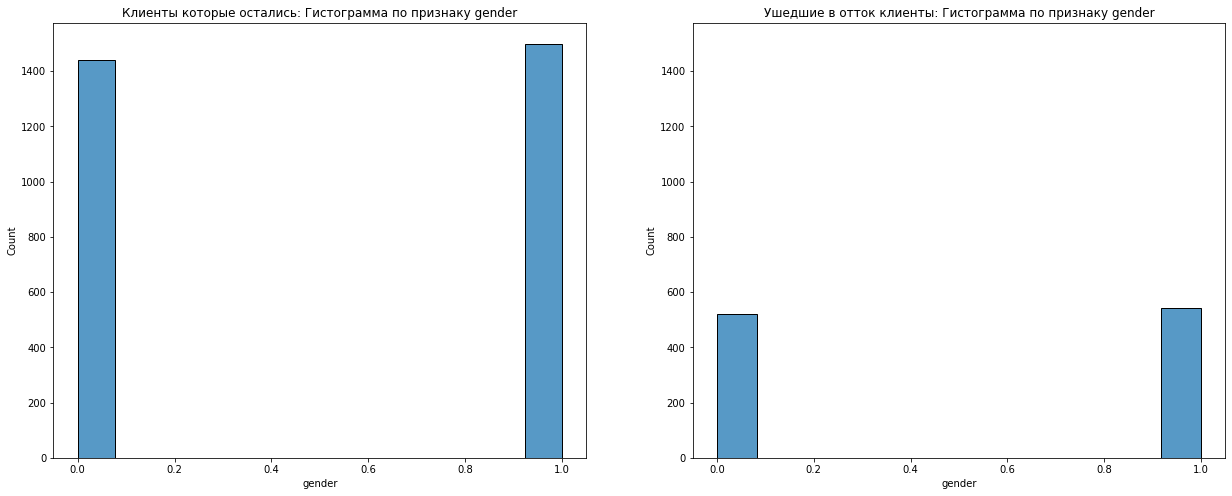

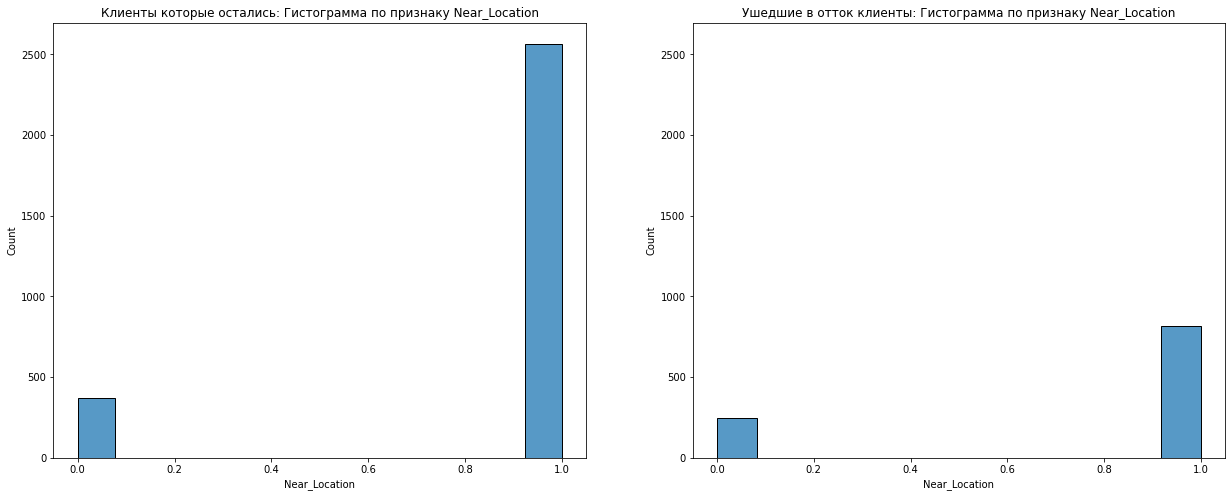

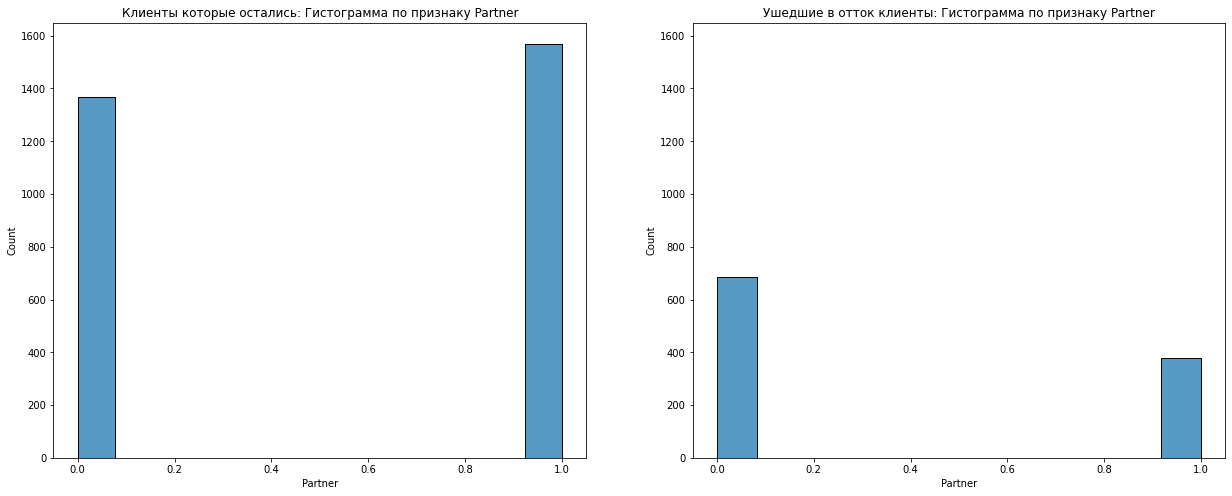

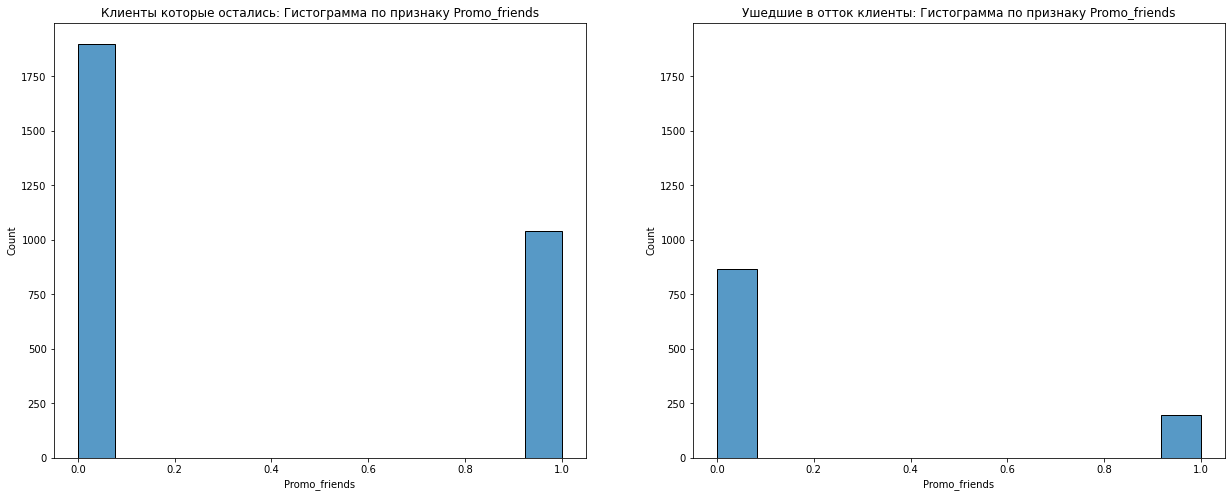

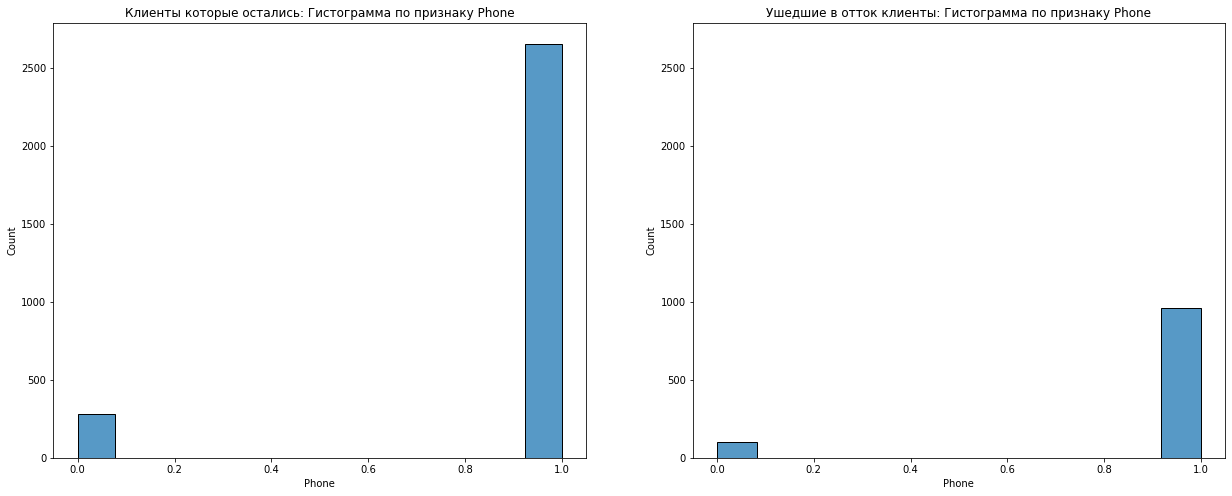

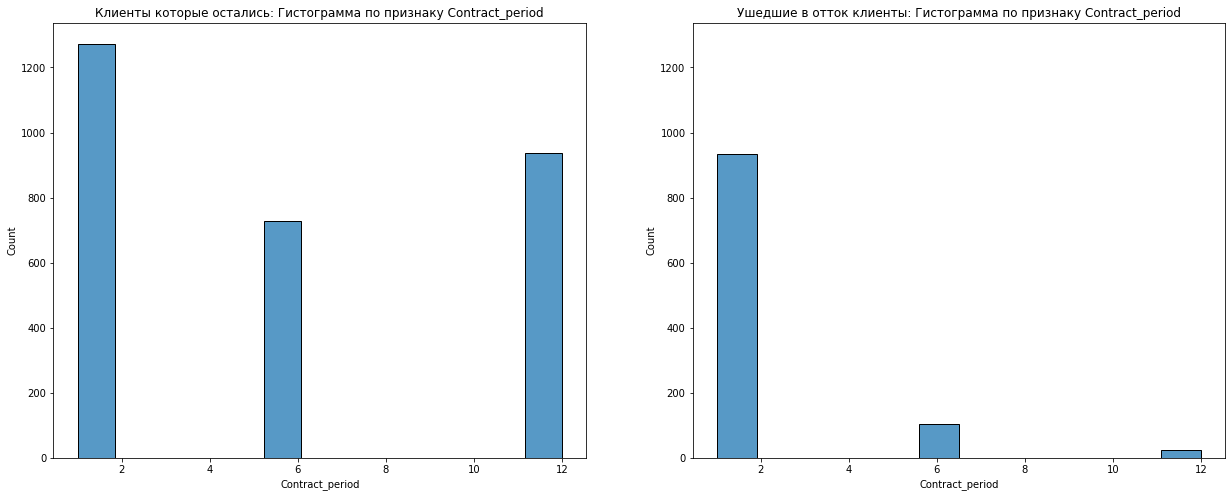

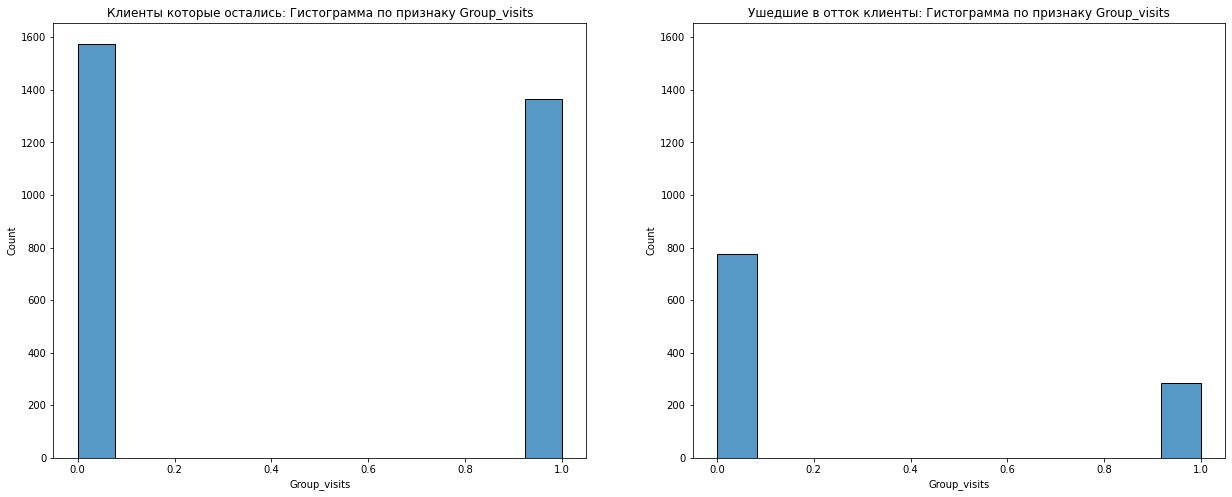

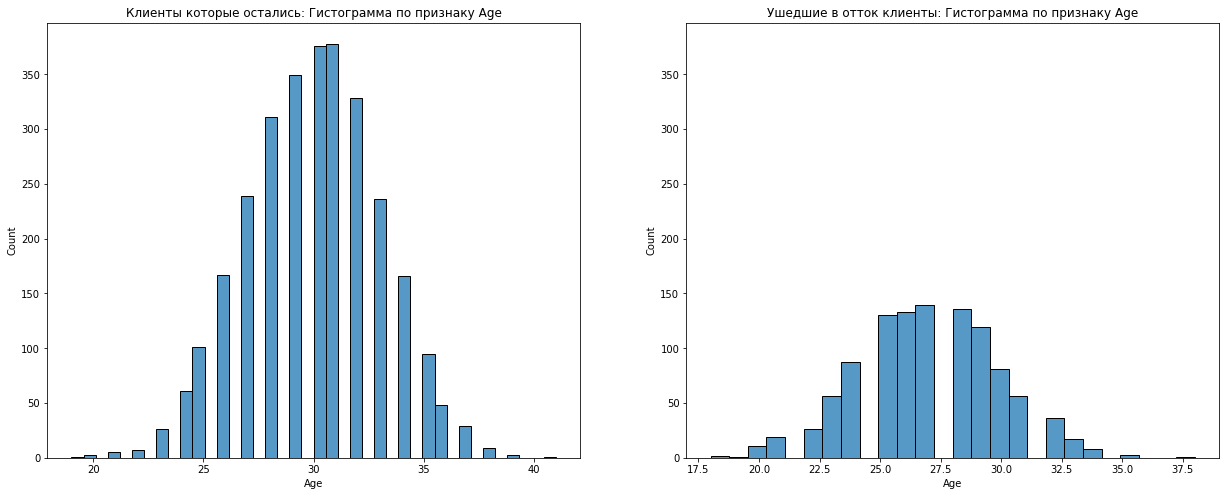

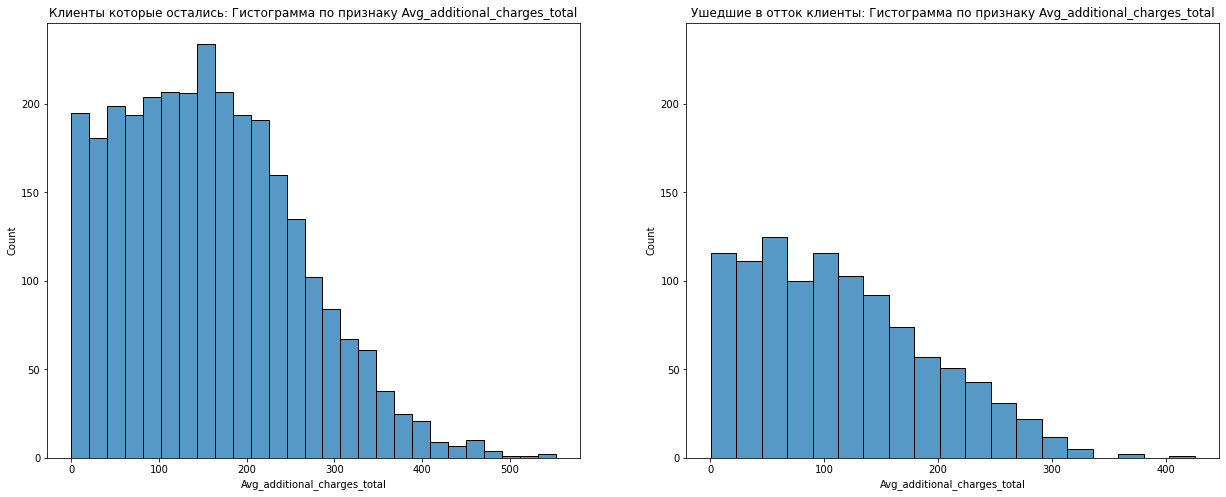

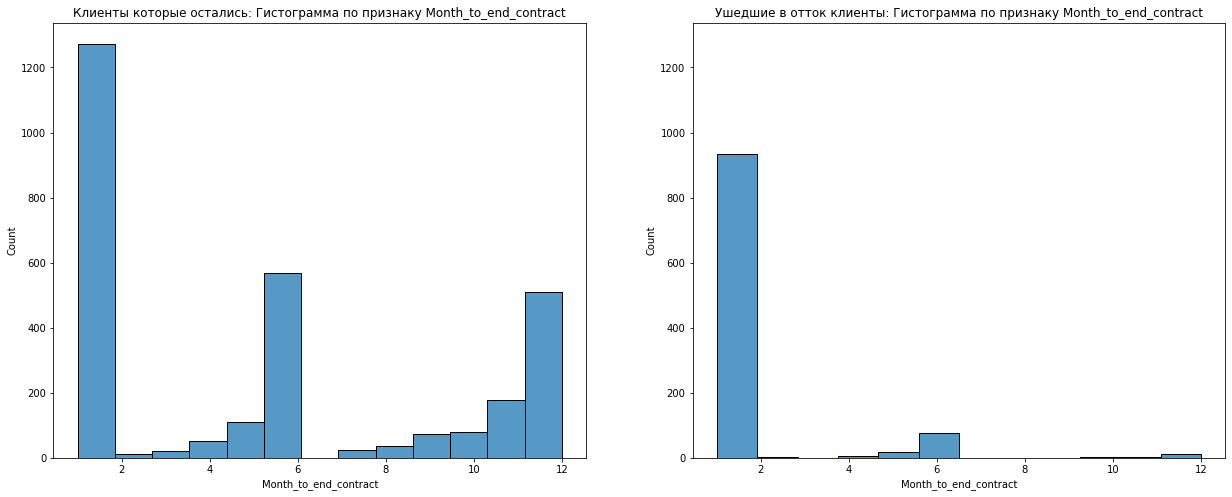

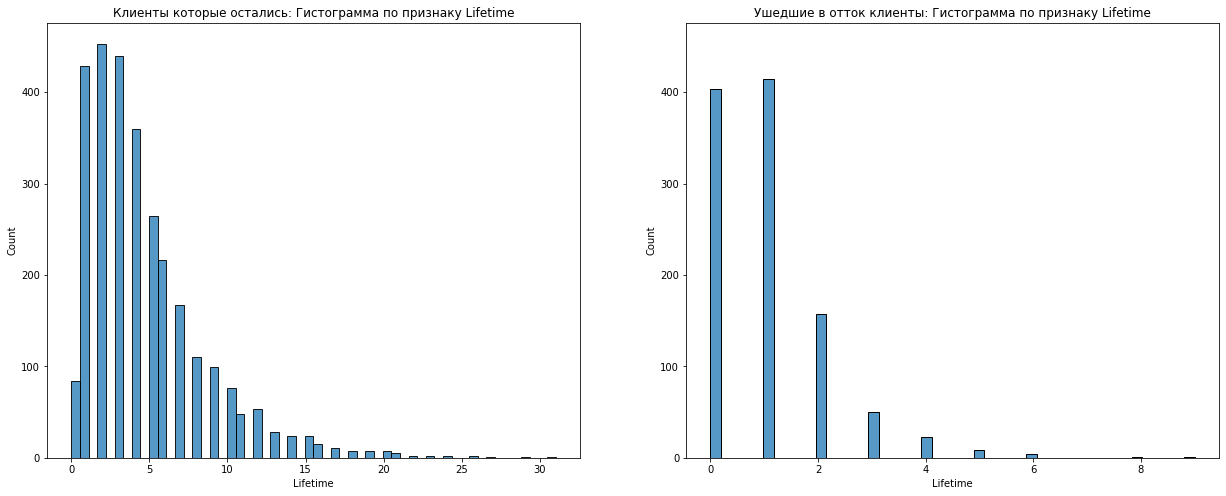

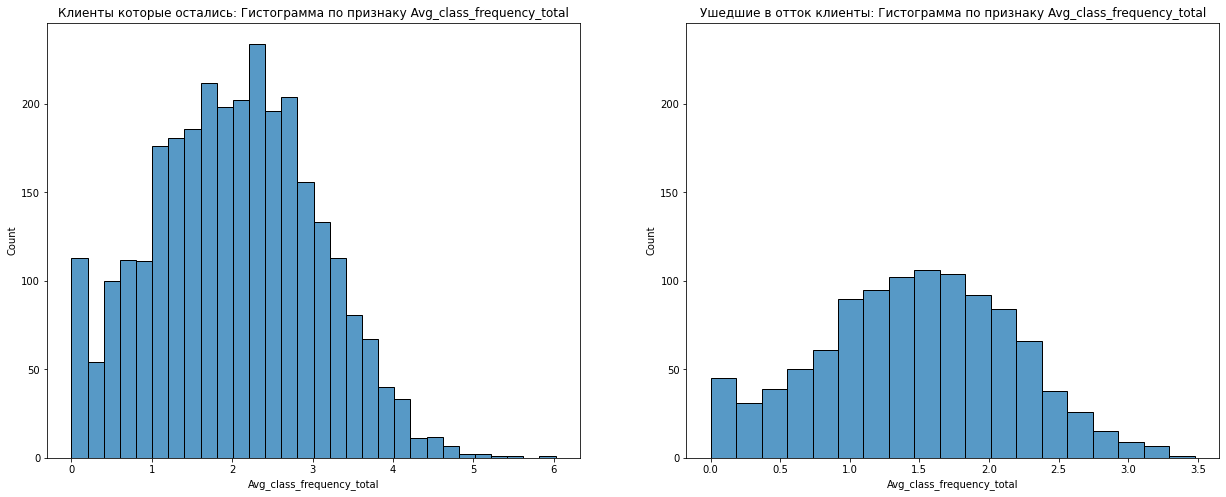

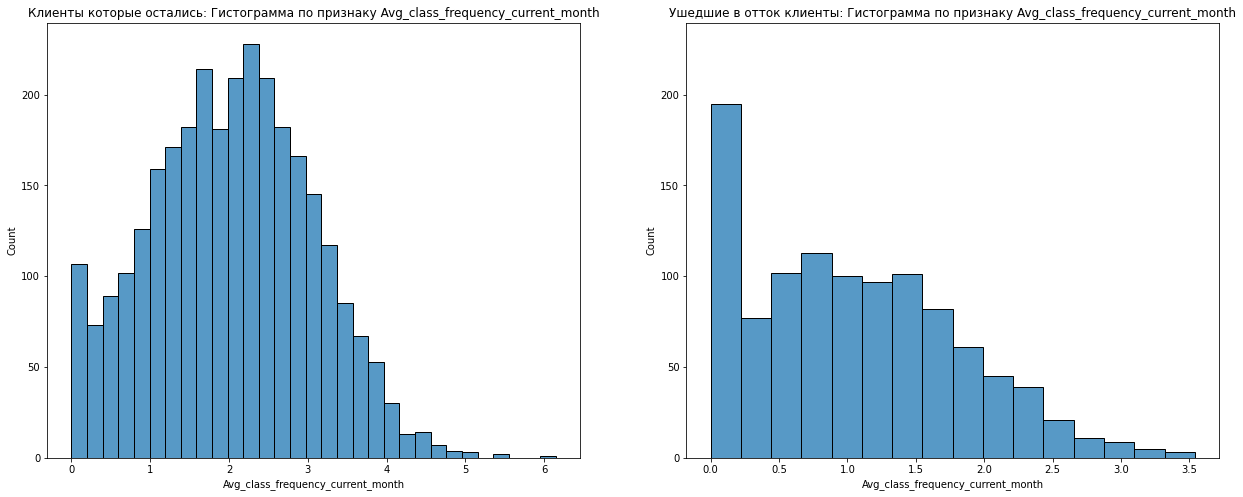

In [6]:
# построим гистограммы признаков с группировкой по оттоку

for column in df.drop('Churn', axis=1).columns:
    
    plt.figure(figsize=(21, 8))
    
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2, sharey=ax1)
    
    sns.histplot(df.query('Churn == 0')[column], ax=ax1)
    ax1.set_title('Клиенты которые остались: Гистограмма по признаку {}'.format(column))
    
    sns.histplot(df.query('Churn == 1')[column], ax=ax2)
    ax2.set_title('Ушедшие в отток клиенты: Гистограмма по признаку {}'.format(column))

Ранее мы уже обратили внимание на определенные черты между признаками с разбивкой по оттоку, теперь давайте детальнее изучим 2 наблюдения: 1- сравним данные между группами и 2 - сравним признаки внутри группы клиентов ушедших в отток.

**1. Сравним данные между группами:**
 - ранее мы уже сравнивали признаки по среднему значения, если просто, взглянуть на пропорции графиков, а не на их количества, то мы видим, что практически по всем признакам графики имеют приблизительно схожие пропорции роста и падения значений. Единственное здесь можно выделить признак компаний-партнеров - здесь на графике оттока доминирует группа, которая не состоит в этой программе. Проще говоря, чаще уходят те клиенты, которые пришли самостоятельно. Количественные признаки затраагивать не будет, ранее мы уже отметили тотже лайфтайм, который у тех кто остается значительно выше, чем у тех кто ушел.
 
**2. Сравним признаки внутри группы клиентов ушедших в отток:**
 - если сравнивать внутри группы то оттоку более подвержены клиенты, которые: 
  - близко распологаются к фитнес-центру,
  - пришедшие самостоятельно, а не через партнерскую программу,
  - взявшие абонемент на месяц,
  - не посещающие групповые занятия,
  - в возрасте от 25 до 29 лет,
  - которые ходят в фитнес-центр менее 2 месяцев.

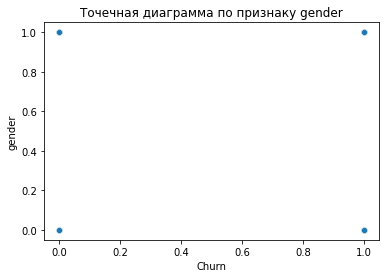

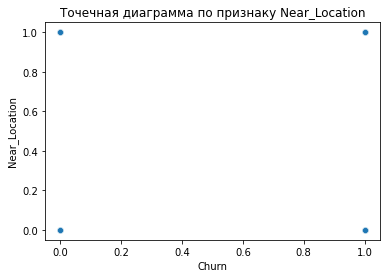

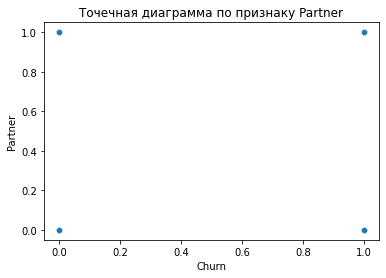

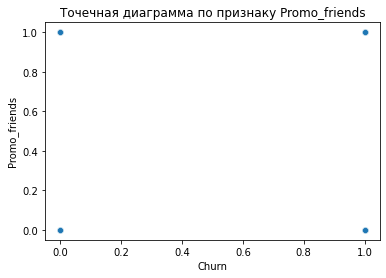

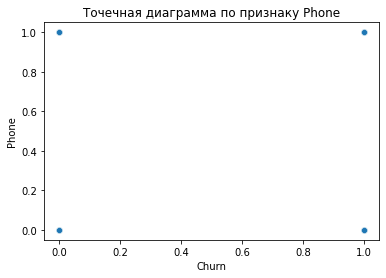

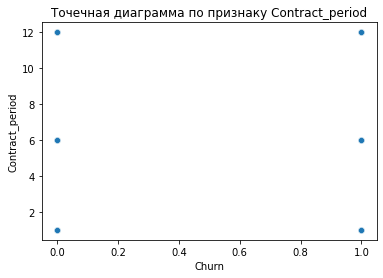

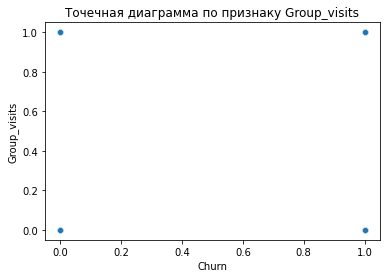

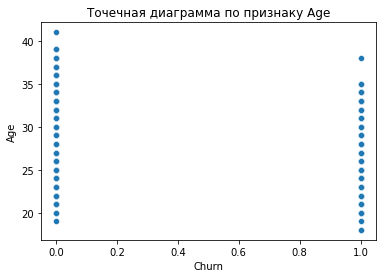

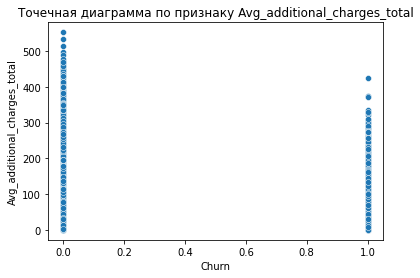

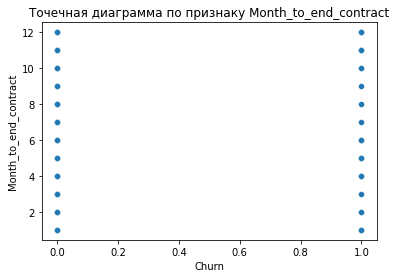

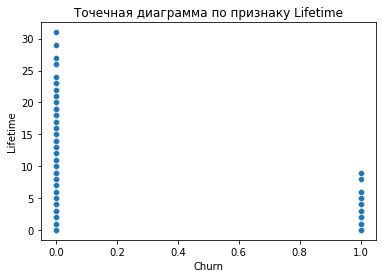

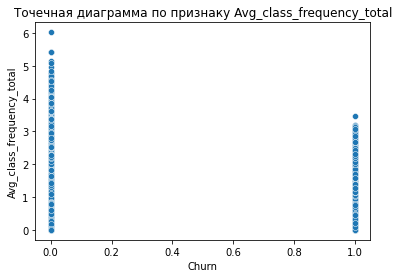

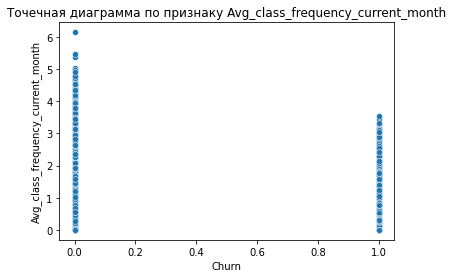

In [7]:
# построим точечную диаграмму

for column in df.drop('Churn', axis=1):
    
    ax = sns.scatterplot(x=df['Churn'], y=df[column])
    ax.set_title('Точечная диаграмма по признаку {}'.format(column))
    
    plt.show()




Видим на точечной диаграмме, что каких-то явных выбросов у нас нет, давайте взглянем на матрицу корреляции.

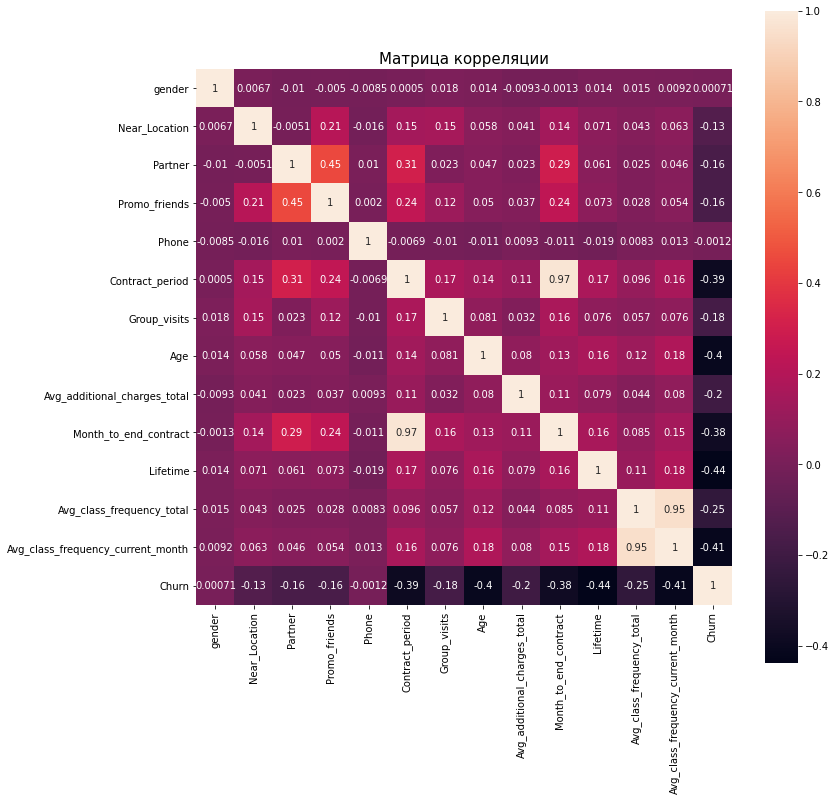

In [8]:
# посмотрим на матрицу корреляции

corr = df.corr()

plt.figure(figsize=(12,12))

plt.title('Матрица корреляции', size=15)
sns.heatmap(corr, annot=True, square=True);

Взглянув на корреляцию, видим, что максимальная отрицательная корреляция целевой переменной с другими признаками составляет около 0,45. Максимально отрицательную корреляцию к целевой переменной имеют следующие признаки:
 - Lifetime,
 - Age,
 - Avg_class_frequency_current_month.
 
Если смотреть на корреляцию между признаками, то можно увидеть сильную положительнную корреляцию у признаков хранящях информацию о длительности и об окончании абонементов, но это и логично.

Давайте удалим по одному мультиколлинеарному признаку, но сначала рассмотрим их подробнее, у нас 2 группы:
 - `Contract_period` (длительность текущего действующего абонемента (1 месяц, 6 месяцев, 12 месяцев)) и `Month_to_end_contract` (срок до окончания текущего действующего абонемента (в месяцах))
 
 
 - `Avg_class_frequency_total` (средняя частота посещений в неделю за все время с начала действия абонемента) и `Avg_class_frequency_current_month` (средняя частота посещений в неделю за предыдущий месяц.)
 
 
Избавимся от следующих признаков:
- `Contract_period` - длительность контракта хоть и интересна, но для нашего исследования нам хватит и срока до окончания абонемента, потому что по нему мы сможем увидить, что клиенты уходят после окончания действия, не хотят продлевать абонемент или может быть еще при действующем абонементе. 

- `Avg_class_frequency_current_month` - несомнено за последний месяц может многое поменятся, например клиенту улетел отдыхать или у него мало свободного времени, но в нашем исследовании будем ориентироваться на частоту посещения за все время, к тому же судя по лайфтайму и период иссследования у нас не сильно большой.

In [9]:
# удалим по одному мультиколлинеарному признаку

df.drop(['Contract_period', 'Avg_class_frequency_current_month'], axis=1, inplace=True)


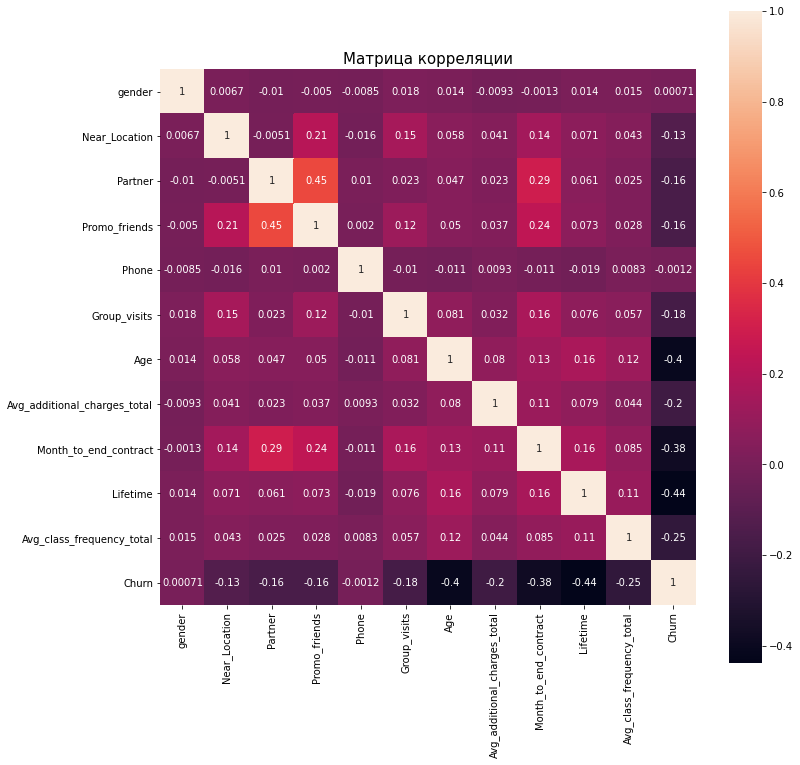

In [10]:
# еще раз построим матрицу корреляции уже с удаленными признаками

corr = df.corr()

plt.figure(figsize=(12,12))

plt.title('Матрица корреляции', size=15)
sns.heatmap(corr, annot=True, square=True);

**Вывод подраздела:**

Мы проверили наши данные и провели EDA-анализ, в ходе которого выяснили:
 - выдвинули несколько предположений, какие признаки могут влиять на отток клиентов;
 - проверили данные на пропущенные признаки;
 - проверили корреляцию к целевой переменной и между признаками;
 - удалили по одному признаку с высокой мультиколлинеарностью.
 
На основе проведенного анализа, можно сказать, что на этих данных можно строить модель.

<a id='3'></a>
## [3. Построение модели прогнозирования](#content)

В этом раздели мы построим модель бинарной класификации, где целевой признак - факт оттока клиента в следующем месяце, для этого:
 - разобъем данные на обучающею и валидационную (тестовую) выборку;
 - будем использовать тип обучения с учителем: классификация;
 - обучим модель двумя алгоритмами: логической регрессии и случайным лесом;
 - оценим метрики для модели.

In [11]:
# разделим наши данные на целемую переменную и признаки
# в качестве целевой переменной будем использовать - столбец `Churn` - факт оттока клиентов в текущем месяце
# разделим выборки в пропорции 80/20

print('Вспомним размер нашей выборки: {}'.format(df.shape))

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print('\nРазмер обучающей выборки: {}'.format(len(X_train)))
print('\nРазмер валидационной (тестовой) выборки: {}'.format(len(X_test)))

Вспомним размер нашей выборки: (4000, 12)

Размер обучающей выборки: 3200

Размер валидационной (тестовой) выборки: 800


In [12]:
# добавим модели логической регрессии и случайного леса

lr_model = LogisticRegression(solver='liblinear', random_state=0)
rf_model = RandomForestClassifier(random_state=0)


# обучим модели

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы

lr_predict = lr_model.predict(X_test)

rf_predict = rf_model.predict(X_test)


In [13]:
# расчитаем метрики и выведем на экран

print('''

Расчет метрик на валидационной (тестовой) выборке:

 1) Для логической регрессии:
    
    - Доля правильных ответов, метрика accuracy: {:.2f}
    
    - Точность, метрика precision: {:.2f}
    
    - Полнота, метрика recall: {:.2f}



 2) Для случайного леса:
 
    - Доля правильных ответов, метрика accuracy: {:.2f}
    
    - Точность, метрика precision: {:.2f}
    
    - Полнота, метрика recall: {:.2f}

'''.format(
    accuracy_score(y_test, lr_predict), 
    precision_score(y_test, lr_predict), 
    recall_score(y_test, lr_predict),
    
    accuracy_score(y_test, rf_predict), 
    precision_score(y_test, rf_predict), 
    recall_score(y_test, rf_predict)

)
    )



Расчет метрик на валидационной (тестовой) выборке:

 1) Для логической регрессии:
    
    - Доля правильных ответов, метрика accuracy: 0.90
    
    - Точность, метрика precision: 0.81
    
    - Полнота, метрика recall: 0.81



 2) Для случайного леса:
 
    - Доля правильных ответов, метрика accuracy: 0.90
    
    - Точность, метрика precision: 0.83
    
    - Полнота, метрика recall: 0.79




**Давайте разберем результаты метрик:**
 - видим, что доля правильных ответов примерно 90% у обоих алгоритмов;
 - точность на 2% лучше у случайного леса - это говорит о том, что случайный лес лучше лучше способен отличать этот класс;
 - а вот с полнотой все наоборот, она на 2% лучше у логической регрессии, соответственно эта модель лучше обнаруживает данный класс вообще.
 
Какуая метрика лучше? Давайте вспомним про **одну из наших целей**: научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента. 

Между метриками разница в +-2%, казалось бы немного, но на общем количестве клиентов которые мы имеем в исследовании (4000) - это поядка 80 человек или говоря проще может быть 80 не проданных абонементов, а ведь эти клиенты могут привести и друзей по акции или членов семьи и тогда их количество может заметно увеличится. 

Исходя из вышеследующего, я считаю, что в данном исследовании нам важна полнота, поскольку она лучше обнаруживает данный класс вообще. Пускай она менее точна, пускай в прогноз попадут клиенты которые не собирались в отток, это ничего, хуже им мы не сделаем :) Уж лучше постораться обнаружить как можно больше потенциальных "оттокеров" :) и предпринять все действия для их удержания.

И именно поэтому здесь **логическая регрессия** нам более предпочтительна!

<a id='4'></a>
## [4. Кластеризация клиентов](#content)

In [14]:
# стандартизируем наши данные

sc = StandardScaler()
X_sc = sc.fit_transform(X)


In [15]:
# поместим в переменную linked «связки» между объектами

linked = linkage(X_sc, method = 'ward') 

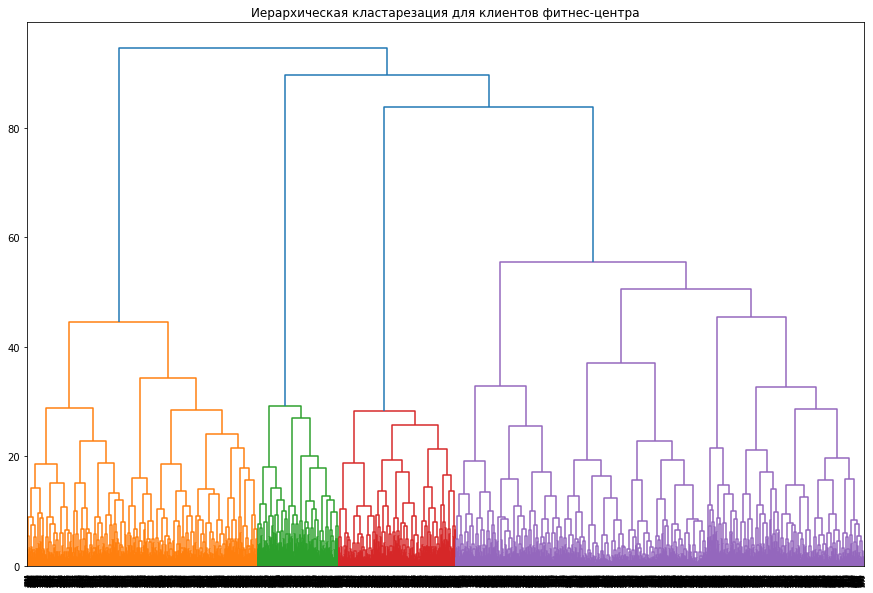

In [16]:
# построим дендограмму на стандартизируемых данных

plt.figure(figsize=(15, 10))  

dendrogram(linked, orientation='top')

plt.title('Иерархическая кластарезация для клиентов фитнес-центра')
plt.show() 

На дендограмме видим, как отчетливо выделяются 4 кластера. Но, вот самый правый класте по размером практически 2-2,5 раза больше остальных кластеров. В дальньнейшем я предлагаю использовать 5 кластеров.

In [17]:
# обучим модель на основании алгоритма K-Means с количеством кластеров = 5

km = KMeans(n_clusters=5, random_state=0)

labels = km.fit_predict(X_sc)


In [18]:
# сохраним метки кластера в поле нашего датафрейма

df['cluster_km'] = labels

In [19]:
# посмотрим на средние значения признаков с группировкой по кластерам
(
    df.groupby('cluster_km', as_index=False)
    .agg({i: 'mean' for i in df.drop('cluster_km', axis=1).columns})
    .sort_values('Churn', ascending=False)
)

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Churn
3,3,0.512090,1.000000,0.196891,0.053541,1,0.297064,27.818653,124.625600,1.898964,2.058722,1.539284,0.506045
1,1,0.500898,0.000000,0.488330,0.077199,1,0.231598,28.685817,137.277472,2.804309,2.978456,1.762672,0.402154
4,4,0.523316,0.862694,0.471503,0.305699,0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839
0,0,0.498501,0.995005,0.889111,1.000000,1,0.519481,29.543457,152.139417,6.265734,4.210789,1.951909,0.132867
2,2,0.521158,0.995546,0.417595,0.011136,1,0.546771,30.805122,177.103564,6.162584,5.701559,2.318701,0.016704


Мы сформулировали 4 кластера и отсортировали их по убыванию среднего оттока в группе, что мы видим:
 
 - **Отток клиентов:**
  - 3 кластер имеет самый большой отток примерно 50%,
  - следом идет 1 кластер, его отток примерно = 40%,
  - 4 кластер и его оттоко около 26%,
  - 0 и 2 кластеры имеют наименьшие оттоки клиентов: около 13% для 0 кластера и около 2% для 2 кластера.
  
  
 - **Пол клиента** - видим что пол роли особо не играет, по всем кластерам среднее близетсяк 50%.
 
 
 - **Близость к фитнес-центру** - видим, что у кластеров с меньшим оттоком среднее выше 86% и стремится к 100%. Но, важно отметить, что два кластера с самыми большими оттоками (3 и 1) поделились надвое, у 3 кластера близость 100%, а у 1 кластера - близость 0%. Делать какие-то выводы по близости сложно, единственное на что можно обратить внимание - это то что у кластера с максимальнным оттоко близость = 100%.
 
 
 - **Компании-партнеры** - можем отметить что чаще уходят в отток клиенты, которые пришли самостоятельнно, а не через компанию-партнера.
 
 
 - **Акция: приведи-друга** - ну здесь тоже можем отметить, что чаще уходят в отток клиенты, которые пришли одни, не пользуясь акцией - их среднее значение находится в диапазоне 5-7%%. Но, важно отметить, что у кластера 2 - у которого наименьший отток - клиенты тоже пришли не по акции, а одни.
 
 
 - **Наличие телефона** - тут стоить отметить, что примерно 26% среди клиентов не оставляющих своего телефона уходят в отток.
 
 
 - **Групповые занятия** - можем заметить, что клиенты уходящие в отток менее заинтересованы в групповых занятиях. Примерно 70% из 3 кластера на них не ходят, а у 1 кластера около 77% не ходят на групповые занятия.
 
 
 - **Возраст** - видим по средним показателям, что оттоку больше подверженны "молодые" клиенты.
 
 
 - **Доп. услуги фитнес-центра** - также стоит отметить, что "экономные" клиенты, те, которые в среднем тратят меньше всего денег на доп. услуги - более подверженны оттоку.
 
 
 - **Окончание действия абонемента** - видим, что оттоку больше подверженны клиенты у которых скоро кончается абонемент (до 3 месяцев)
 
 
 - **Лайфтайм** - также стоит отметить, что здесь схожая взаимосвязь, что и у предыдущего признака. Клиенты ходившие в фитнес-центр менее 3 месяцев - больше подвержанны оттоку.
 
 
 - **Частота посещения в неделю** - чем меньше частота посещения, тем больше вероятность что клиент уйдет в отток.


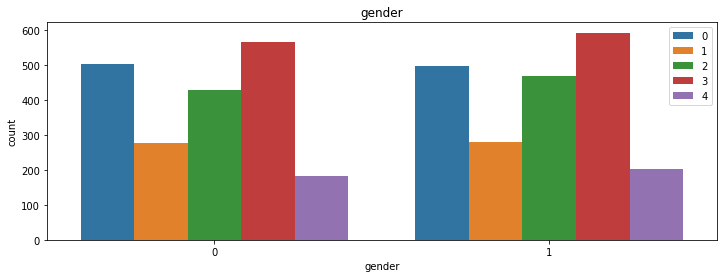

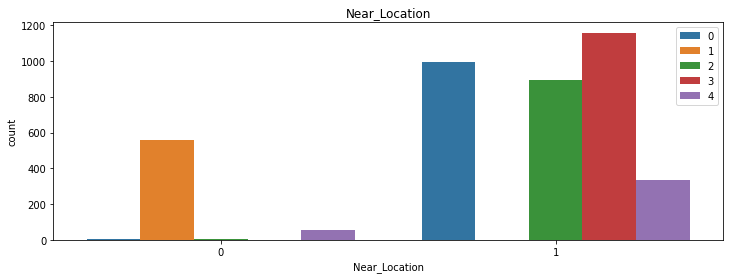

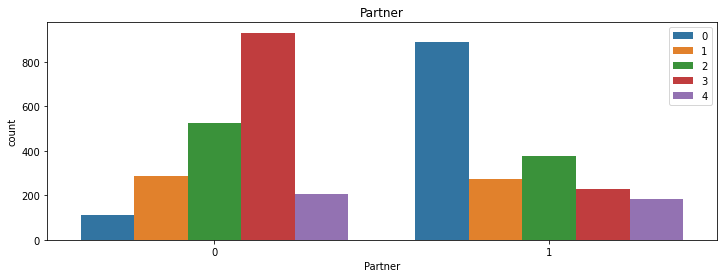

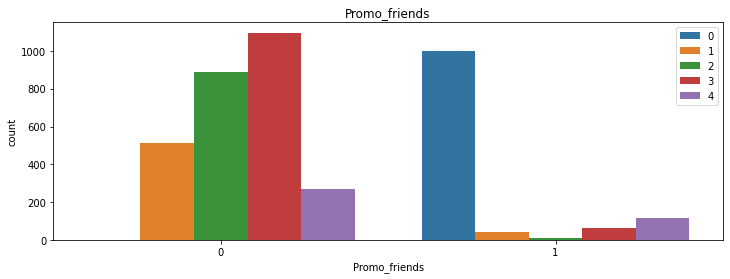

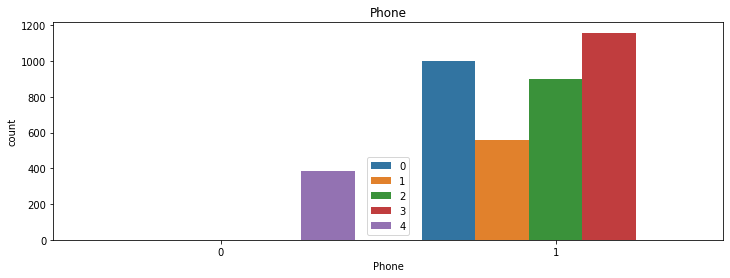

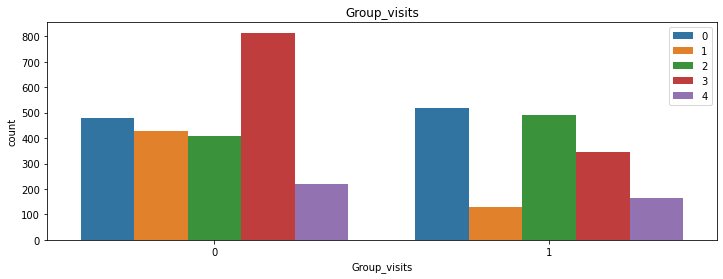

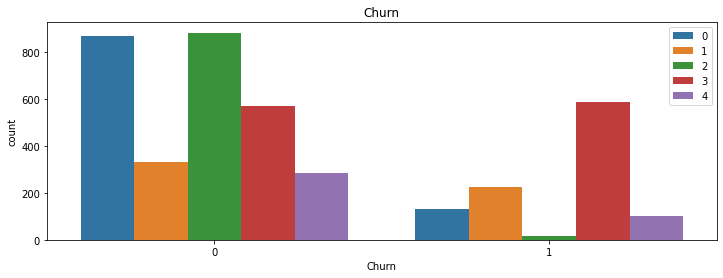

In [20]:
# отрисуем графики для категориальнных переменных

categorical_columns = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Group_visits', 'Churn']

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.legend()
    plt.show()

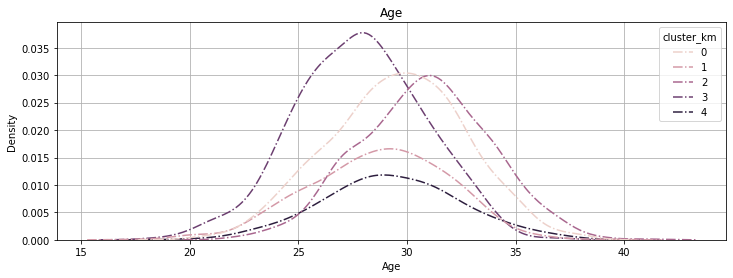

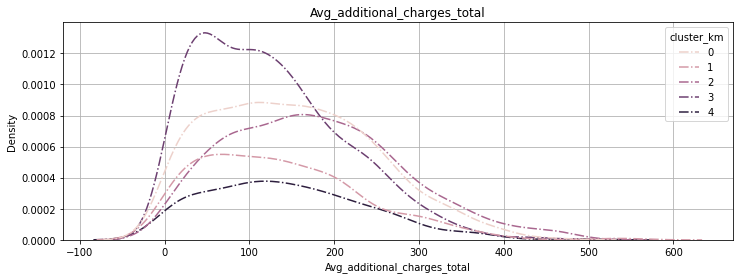

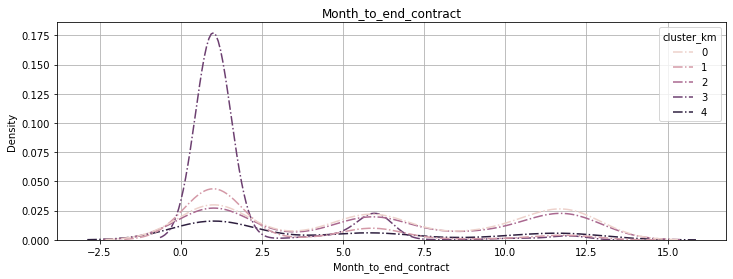

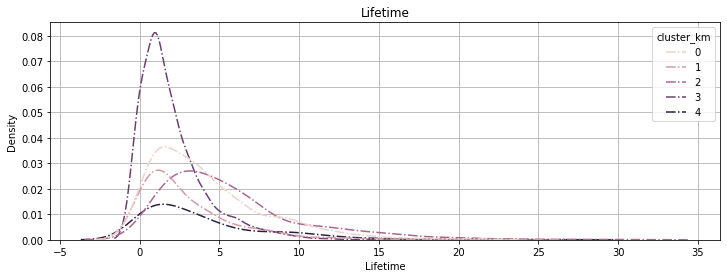

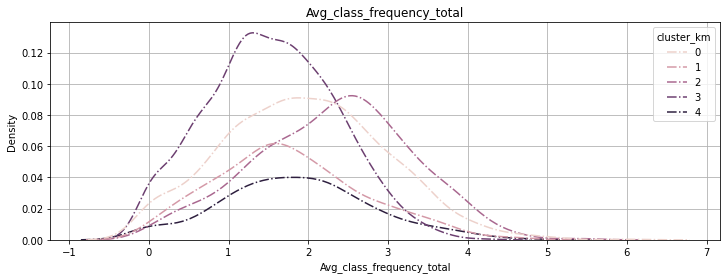

In [21]:
# построим графики для численных переменных

columns = ['Age', 'Avg_additional_charges_total',
       'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total']

for column in columns:
    
    
    plt.figure(figsize=(12, 4))
        
    sns.kdeplot(x=df[column], hue='cluster_km', data=df, legend=True, linestyle='dashdot')
    
    plt.title(column)
    plt.grid()
    plt.show()

Сложно найти какие-то явные отличия по графикам, за исключением тех наблюдений, которые мы уже отметили ранее.

 - можно добавить, что средний вес по всем кластерам в диапазоне 27-30 лет,
 - 3 кластер самый экономный, его лайфтайм около 2-2,5 месяцев. У этого кластера скоро кончается абонемент, как видно из графика приблизительно до 2 месяцев
 

<a id='5'></a>
## [5. Вывод исследования](#content)

В рамках нашего исследования мы выявили несколько признаков, которые подвержены клиенты уходящие в отток:
 - **Срок абонемента** - из исследования мы заметили, что оттоку подвержены те клиенты, абонемент которых скоро кончается (менее 1 месяца), а также которые купили абонемент всего на 1 месяц. Возможно стоит изучить минимальную длительнность абонементов и постараться сделать ее увеличить, но тут надо проводить дополнительнное исследование, посколько это может привести к уменьшению клиенто-потока в фитнес-центр. В качестве альтернативы можно расмотреть акцию на продления абонемента или подарить 2 месяц, и сдесь опять же надо проводить дополнительнные исследования, потому что мы не знаем наверняка удержит это клиентов или нет.
 - **Групповые занятия** - еще один признак, который у клиентов ушедших в отток меньше остальных. Можем предположить, что клиенты не посещающие групповые занятия чаще уходят в отток. Возможно стоит пересмотреть стратегию по привлечению клиентов к групповым занятиям или возможно пересмотреть весь перечень групповых занятий, вполне возможно, что в списке нет подходящих занятий для этой доли клиентов и они могут уйти в отток из-за этого.
 - **Частота посещения в неделю** - у тех клиентов, которые уходят в отток она меньше 1,5 в неделю. Причин может быть множество: мало свободного времени на посещение фитнес-центра, или неудобно добираться, а возможно и то, что пропало желание заниматься. Можно попробовать привлечь эту подгруппу клиентов к групповым занятиям, которые идут 2 раза в неделю, таким образом у клиента появится расписание тренировок, возможно это положительно скажется на его посещаемости. Можно попробовать звонки таким клиентам с целью мотивации их к тренировкам, или проведения специальных акций.
 - **Лайфтаймы** - исследование показало, что больше всего уходят клиенты с маленькими лайфтаймами, они ходили в фитнес-центр менее 2 месяцев. Надо попробовать их удержать на более длительный срок, возможно специальными акциями или опять же групповыми занятиями. Возможно из-за неправильного подхода к тренировкам клиенты не видели результата своих занятий и уходили в отток, можно попробовать предлогать таким клиентам фитнес-тренера, который составит им программу тренировок и будет первое время за ними присматривать, но тут сразу стоит обратить внимание и на следующий признак - **затраты на доп. услуги фитнес-центра** по которому мы видим, что клиенты подвержанные оттоку меньше всего тартят, назовем их экономными, поэтому услуги фитнес тренера можно попытаться сделать для них доступнее. 
 - **Затраты на доп. услуги фитнес-центра** как мы ранее ответили, клиенты уходящие в отток меньше всего тратят деньги на доп. услуги, можно попробовать пересмотреть прайс-цен на эти услуги, или делать акции на них, возможно некторое услуги оказать бесплатно первый раз с целью заинтересовать клиента.